In [1]:
import math
import numpy as np
from scipy.optimize import fsolve
# import sympy as sy
from matplotlib import pyplot as plt
from scipy.integrate import quad

In [87]:
# Hillslope 1, Scenario 2
Bx = 300                                          # slope length, in m
theta = math.radians(0.1)                         # slope angle, in radians
# I will try theta from pi/1800 radians (as for Hillslope 1, slope close to 0.001) to pi/4 (slope = 1)
theta = math.pi/30    # hillslope 2, slope close to 0.1
theta = math.pi/30

k0 = 230                                          # hydraulic conductivity (in m/d)
# can try different orders of magnitude for k0
# e.g. 1, 10, 100, 1000, 10000
# k0 = 10000
k0 = 8.64     # hillslope 2

ne = 0.15                                         # drainable porosity
# drainable porosity occurs on a scale 0-1
# ne = 1
ne = 0.34   # hillslope 2

eta0 = 0.67                                       # mean water table height, in m
tstar = Bx*ne/(k0*math.sin(theta))  # response timescale, in days (this one should work out to 112.10 with the original parameter values)
H_i = 0.78                                        # hillslope number

H_i = 47.29     # hillslope 2

H_i = Bx * math.tan(theta) / eta0

Rmax = 0.01
D = 1.5

H_r = Bx**2*Rmax/(D*k0*eta0*math.cos(theta))

xr = 150
td = 1000
alpha = 0
gamma = 0

a = -H_i**2/4
b = -H_i/2


In [88]:
# Trying to find transcendental roots

def func_find_lambda_n(x):
    return math.tan(x[0]) + 2*x[0]/(300 * math.tan(theta)/eta0)

# Finding the first 1000 transcendental roots:
transcendental_lambda_n = []
for m in range(1001):
    # note that the transcendental roots converge to (2m-1)pi/2 as m -> infinity
    if m > 0:
        near = (2*m - 1)*math.pi/2
    else:
        near = m*math.pi
    root = fsolve(func_find_lambda_n, [near])
    transcendental_lambda_n.append(root[0])

# remove 0 from the list
transcendental_lambda_n.pop(0)

# print(transcendental_lambda_n)

phi_squared_int = 0.5 # integrating phi_n^2 over x in [0,1]



# Finding coefficients C_n

def f1(x, lambda_m):
    return np.exp(-b * x) * np.sin(lambda_m * x)


list_C_n = []

for n in range(1000):
    result_numer, error_numer = quad(f1, 0, 1, transcendental_lambda_n[n], limit = 1000)
    C_n = result_numer/phi_squared_int
    list_C_n.append(C_n)


# Finding coefficients capital phi_n

N = np.zeros(Bx)
for i in range(len(N)):
    if i >= xr:
        N[i] = 1
    else:
        N[i] = alpha

def cap_phi_integrand(x, lambda_n):
    x_ind = round(x*299)
    # print(str(x_ind) + ": " + str(N[x_ind]))
    return H_r*N[x_ind]*np.exp(-b*x)*np.sin(lambda_n*x)

cap_phi_list = []

for lambda_n in transcendental_lambda_n:
    result, error = quad(cap_phi_integrand, 0, 1, args = (lambda_n), limit = 200)

    cap_phi_n = result/phi_squared_int

    cap_phi_list.append(cap_phi_n)


cap_phi_list_Table1 = []

# should I use xr as 0.5 (non dimensional) or 150?
# maybe use x_r = 0.5
x_r = 0.5
for i in range(1000):
    # build denominator for coefficient
    lambda_n = transcendental_lambda_n[i]
    denominator = (b**2 + lambda_n**2) * (np.sin(2 * lambda_n) - 2 * lambda_n)
    # print(lambda_n)
    # print(denominator)
    
    # build numerator
    numerator = 4 * np.exp( -b * (x_r + 1))
    numerator = numerator * H_r * lambda_n
    numerator = (numerator * (b * ( (alpha - 1) * np.exp(b) * np.sin(x_r * lambda_n) + np.exp(b * x_r) * np.sin(lambda_n)) + 
                             lambda_n * (np.exp(b) * ((alpha - 1) * np.cos(x_r * lambda_n) - alpha * np.exp(b * x_r)) + 
                                        np.exp(b * x_r) * np.cos(lambda_n))))

    cap_phi_Table1 = numerator/denominator

    cap_phi_list_Table1.append(cap_phi_Table1)

# these two lists of capital phi coefficients are identical to many decimal places. like. many
# for i in range(len(cap_phi_list)):
#     print(str(i) + ": " + str(cap_phi_list[i]) + ", " + str(cap_phi_list_Table1[i]))


def cn_givenM(t, lambda_n, n):
    C_n  = list_C_n[n]
    # Phi_n = cap_phi_list[n]
    Phi_n = cap_phi_list_Table1[n]
    
    depends_t = (1 - np.exp(a * t - t*lambda_n**2))/(a - lambda_n**2)
    td = 1

    if t > td:
        gamma = 0
        depends_t = ((gamma - 1)*np.exp(-a * td + a * t + td * lambda_n**2 - t * lambda_n**2) + np.exp(a * t - t * lambda_n**2) - gamma)
        depends_t = depends_t/(lambda_n**2 - a)

    prod = np.exp(-a*t)
    prod = prod * (C_n*np.exp(a * t - t * lambda_n**2) - Phi_n*(depends_t))

    cn_t = prod

    return cn_t


def eta(x, t):
    trunc_inf_sum = 0

    # print(np.exp(a * t + b * x))
    for n in range(0, 1000):
        lambda_n = transcendental_lambda_n[n]
        term_n = cn_givenM(t,lambda_n, n)*np.sin(lambda_n * x)

        # print(str(n) + ": " + str(term_n))
        
        trunc_inf_sum += term_n
        
    return np.exp(a * t + b * x)*trunc_inf_sum

print(eta(0.1,0))

0.37967628698612166


/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_1015/1667391842.py:105: RuntimeWarning: overflow encountered in exp
  prod = np.exp(-a*t)
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_1015/1667391842.py:119: RuntimeWarning: invalid value encountered in scalar multiply
  term_n = cn_givenM(t,lambda_n, n)*np.sin(lambda_n * x)
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_1015/1667391842.py:106: RuntimeWarning: invalid value encountered in scalar multiply
  prod = prod * (C_n*np.exp(a * t - t * lambda_n**2) - Phi_n*(depends_t))
/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_1015/1667391842.py:123: RuntimeWarning: invalid value encountered in scalar add
  trunc_inf_sum += term_n


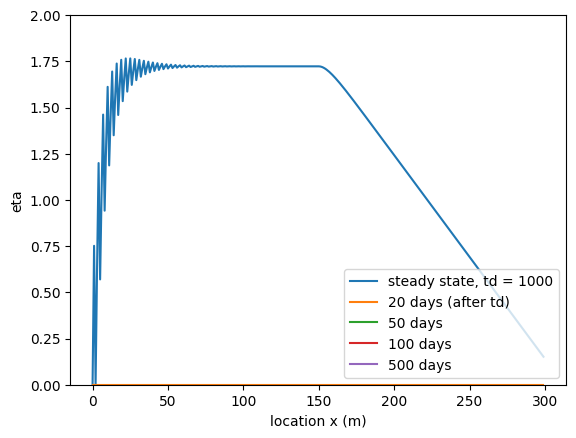

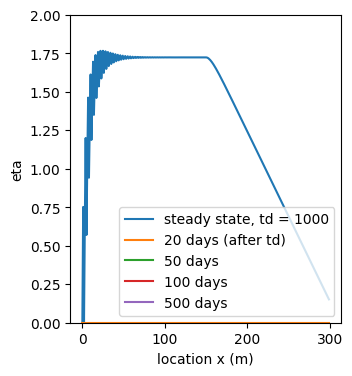

In [89]:
xvals = []
etavals_eq = []
etavals_20days = []
etavals_50days = []
etavals_100days = []
etavals_500days = []


etavals_20after0 = []
etavals_0 = []
etavals_1 = []
etavals_50 = []



for i in range(300):
    xval = i/300
    xvals.append(xval)

    const = (k0 * eta0 * math.cos(theta))/(ne * Bx**2)
    const = 1

    td = 1
    # td = 1000/tstar
    div = td
    div = 1000
    div = tstar

    eta_div = 0.67
    # eta_div = 1
    
    tval_td = td 
    etaval_eq = eta(xval, tval_td * const)/ eta_div
    etavals_eq.append(etaval_eq)

    # print(str(i) + ": " + str(etaval))
    tval_20 = td + 20/div
    etaval_20 = eta(xval, tval_20 * const)/ eta_div
    etavals_20days.append(etaval_20)

    tval_50 = td + 50/div
    etaval_50 = eta(xval, tval_50 * const)/ eta_div
    etavals_50days.append(etaval_50)

    tval_100 = td + 100/div
    etaval_100 = eta(xval, tval_100 * const)/ eta_div
    etavals_100days.append(etaval_100)

    tval_500 = td + 500/div
    etaval_500 = eta(xval, tval_500 * const)/ eta_div
    etavals_500days.append(etaval_500)



xvals_dimensional = list(map(lambda x: x*300, xvals))

plt.plot(xvals_dimensional, etavals_eq, label = "steady state, td = 1000")

plt.plot(xvals_dimensional, etavals_20days, label = "20 days (after td)")

plt.plot(xvals_dimensional, etavals_50days, label = "50 days")

plt.plot(xvals_dimensional, etavals_100days, label = "100 days")

plt.plot(xvals_dimensional, etavals_500days, label = "500 days")


plt.xlabel('location x (m)')
plt.ylabel('eta')
plt.ylim(0, 2)
plt.legend(loc = "lower right")

plt.show()

f = plt.figure()
f.set_figwidth(3.5)
f.set_figheight(4)


plt.plot(xvals_dimensional, etavals_eq, label = "steady state, td = 1000")

plt.plot(xvals_dimensional, etavals_20days, label = "20 days (after td)")

plt.plot(xvals_dimensional, etavals_50days, label = "50 days")

plt.plot(xvals_dimensional, etavals_100days, label = "100 days")

plt.plot(xvals_dimensional, etavals_500days, label = "500 days")

plt.xlabel('location x (m)')
plt.ylabel('eta')
plt.ylim(0, 2)
plt.legend(loc = "lower right")

plt.show()

    

In [53]:
a

-559.086025